In [1]:
import os
import shutil as sh
import glob
import json
import datetime

import numpy as np
import nibabel as ni

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from scipy.io import loadmat
import h5py
import cv2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

print(tf.__version__)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
%load_ext tensorboard

2.0.0
3 Physical GPUs, 1 Logical GPUs


In [185]:
from IPython.display import clear_output

In [3]:
from tensorflow.keras import backend as K

def weighted_loss(weights):
    def loss(y_true, y_pred):
        L = keras.losses.categorical_crossentropy(y_true,y_pred, from_logits=True)
        y_true_mask = K.argmax(y_true, axis=-1)
        final_L = tf.zeros_like(L)
        for i in range(weights.shape[0]):
            mask = weights[i] * K.cast(K.equal(y_true_mask, i), dtype=K.dtype(L)) * L
            final_L += mask
        return final_L
    return loss

In [4]:
# y = np.zeros((32,256,256,2))
# y[:,:,:,0] = 1.0
# y_true = tf.convert_to_tensor(y)

# y = np.zeros((32,256,256,2))
# y[:,:,:,1] = 1.0
# y_pred = tf.convert_to_tensor(y)

# weights = np.array([0.1, 1])

# weighted_loss(weights)(y_true, y_pred).numpy().mean(axis=0)

In [5]:
def DenseBlock(inp, name, max_pool=False):
    fp1 = layers.Conv2D(64, (5,5), activation='relu', padding='SAME', name = name + '_Conv1')(inp)
    fp1 = layers.BatchNormalization(name=name + '_BatchNorm1')(fp1)
    con1 = layers.Concatenate(name=name+'_Concat1')([inp, fp1])
    fp2 = layers.Conv2D(64, (5,5), activation='relu', padding='SAME', name = name + '_Conv2')(con1)
    fp2 = layers.BatchNormalization(name=name + '_BatchNorm2')(fp2)
    con2 = layers.Concatenate(name=name+'_Concat2')([inp, fp1, fp2])
    res = layers.Conv2D(64,(1,1), activation='relu', padding='SAME', name=name+'_OutDense')(con2)
    res = layers.BatchNormalization(name=name + '_BatchNorm3')(res)
    
    if max_pool:
        max_p = layers.MaxPool2D(pool_size=(2,2), name=name+'_Maxpool1')(res)
        return res, max_p
    return res

inp = layers.Input(shape=(256,256,1), name='InputLayer')
x = inp
skip = list()
for i in range(4):
    s, x = DenseBlock(x, 'Dense{0}'.format(i+1), max_pool=True)
    skip.append(s)


x = layers.Conv2D(64, (5,5), name='BottleNeck_Conv', padding='SAME')(x)
x = layers.BatchNormalization(name='BottleNeck_Normalization')(x)

for i in range(4):
    x = layers.UpSampling2D(size=(2,2), name='Up-pool{0}'.format(i+1))(x)
    x = layers.Concatenate(name='Concat{0}'.format(i+1))([x, skip[-i-1]])
    x = DenseBlock(x, 'Up_Dense{0}'.format(i+1))
    
outp = layers.Conv2D(4, (1,1), activation='softmax', name='OutputLayer')(x)
model = Model(inp, outp, name='ErfanNet')

weights = np.array([0.1, 1.0, 1.0, 1.0])
model.compile(loss=weighted_loss(weights), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
# model.summary()
# plot_model(model, show_shapes=True)

In [6]:
file = glob.glob('Dataset/*.mat')

In [7]:
images = list()
masks = list()
for fil in file:
    with h5py.File(fil,'r') as f:
        lbl = np.array(f['cjdata']['label']).flatten()
        img = cv2.resize(np.array(f['cjdata']['image']), (256,256))
        mask = lbl * cv2.resize(np.array(f['cjdata']['tumorMask']), (256,256))
        images.append(img)
        masks.append(mask)

images = np.array(images)
masks = np.array(masks)

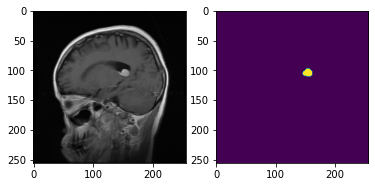

In [8]:
sample = np.random.randint(0,len(images))

plt.subplot(1,2,1)
plt.imshow(images[sample,:,:].T, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(masks[sample,:,:].T)

In [9]:
tt = np.count_nonzero(masks)
s,m,n = masks.shape
masks.max(), 100 * (1 - tt / (s*m*n))

(3.0, 98.28433492476262)

In [10]:
images = np.expand_dims(images, axis=-1)
masks = keras.utils.to_categorical(masks, num_classes=4)

In [11]:
masks.shape, masks.max()

((3064, 256, 256, 4), 1.0)

In [12]:
index = np.random.permutation(range(len(images)))

total_train = int(len(images)*0.7)

train_x = images[index[:total_train]]
train_y = masks[index[:total_train]]
test_x = images[index[total_train:]]
test_y = masks[index[total_train:]]

In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="model/logs/", histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model/weights/epoch_{0}.h5'.format('{epoch:03d}'))
model_best_callback = tf.keras.callbacks.ModelCheckpoint('model/best_model.h5', monitor='val_loss', save_best_only=True)

In [27]:
Epochs = 200

In [14]:
history = model.fit(train_x, train_y, validation_data=(test_x,test_y), 
                    epochs=Epochs, batch_size=16, 
                    workers=1, use_multiprocessing=False, shuffle=True, 
                    callbacks=[tensorboard_callback, model_checkpoint_callback, model_best_callback])

Train on 2144 samples, validate on 920 samples
Epoch 1/200
2144/2144 [==============================] - 82s 38ms/sample - loss: 0.1192 - accuracy: 0.7661 - val_loss: 0.1151 - val_accuracy: 0.7999
Epoch 2/200
2144/2144 [==============================] - 71s 33ms/sample - loss: 0.1085 - accuracy: 0.8517 - val_loss: 0.1079 - val_accuracy: 0.8397
Epoch 3/200
2144/2144 [==============================] - 71s 33ms/sample - loss: 0.1032 - accuracy: 0.8866 - val_loss: 0.0982 - val_accuracy: 0.9231
Epoch 4/200
2144/2144 [==============================] - 70s 33ms/sample - loss: 0.0998 - accuracy: 0.9103 - val_loss: 0.1009 - val_accuracy: 0.8739
Epoch 5/200
2144/2144 [==============================] - 70s 33ms/sample - loss: 0.0975 - accuracy: 0.9268 - val_loss: 0.0964 - val_accuracy: 0.9155
Epoch 6/200
2144/2144 [==============================] - 70s 32ms/sample - loss: 0.0962 - accuracy: 0.9361 - val_loss: 0.0990 - val_accuracy: 0.8855
Epoch 7/200
2144/2144 [==============================] - 70

In [15]:
with open('model/history.pk', 'wb') as f:
    pickle.dump(history.history, f)

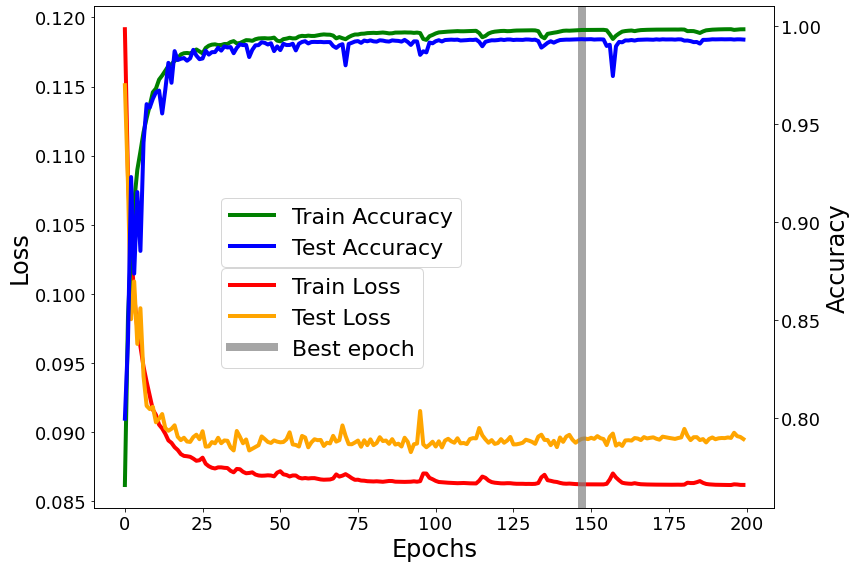

In [287]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

fig, ax1 = plt.subplots(figsize=(12,8))
#plt.title('QuickTumorNet learning curve - Max accuracy on test is {0:.2%}'.format(max(history.history['val_accuracy'])), fontsize=24)

ax1.set_xlabel('Epochs', fontsize=24)
#ax1.set_xticks(range(Epochs))
ax1.set_ylabel('Loss', fontsize=24)
ax1.plot(range(Epochs), history.history['loss'], 'r', label='Train Loss', linewidth=4)
ax1.plot(range(Epochs), history.history['val_loss'], 'orange', label='Test Loss', linewidth=4)
ax1.axvline(best_epoch, color='gray', lw=8, alpha=0.7, label='Best epoch')
ax1.legend(bbox_to_anchor=(0.5, 0.5), fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=18)

ax2 = ax1.twinx()

ax2.set_ylabel('Accuracy', fontsize=24)
ax2.plot(range(Epochs), history.history['accuracy'], 'g', label='Train Accuracy', linewidth=4)
ax2.plot(range(Epochs), history.history['val_accuracy'], 'b', label='Test Accuracy', linewidth=4)
ax2.legend(bbox_to_anchor=(0.556, 0.64), fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
plt.savefig('ModelLearningCurve.png')
plt.show()

In [82]:
test_x.shape

(920, 256, 256, 1)

In [103]:
import time
t = time.time()
# do stuff
elapsed = time.time() - t

In [110]:
model = load_model('model/weights/epoch_199.h5', custom_objects={'loss': weighted_loss(weights)})

In [111]:
t = time.time()
prob = model.predict(test_x.astype('float32'))
elapsed = time.time() - t
print('Time per each slice: {0}'.format(elapsed/len(test_x)))

Time per each slice: 0.019252518726431807


In [112]:
y_hat = np.argmax(prob, axis=-1)
y = np.argmax(test_y, axis=-1)

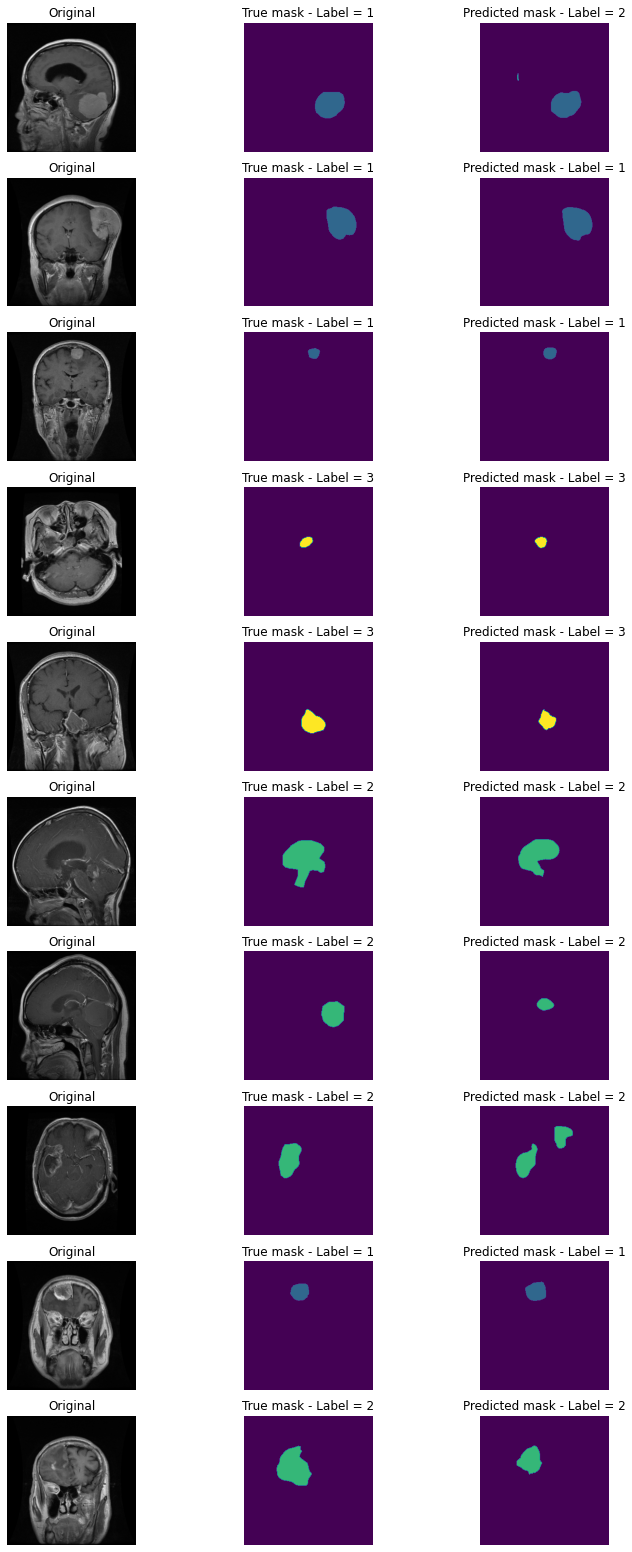

In [114]:
samples = np.random.permutation(range(len(test_x)))

L = 10
plt.figure(figsize=(12,8+2*L))
for i in range(L):
    sample = samples[i]
    plt.subplot(L,3,i*3+1)
    #if i == 0:
    plt.title('Original')
    plt.imshow(test_x[sample,:,:,0].T, cmap='gray')
    plt.axis('off')
    plt.subplot(L,3,i*3+2)
    lbl = y[sample,:,:].max()
    #if i == 0:
    plt.title('True mask - Label = %d' % lbl)
    plt.imshow(y[sample,:,:].T, vmin=0, vmax=3)
    plt.axis('off')
    plt.subplot(L,3,i*3+3)
    lbl = y_hat[sample,:,:].max()
    #if i == 0:
    plt.title('Predicted mask - Label = %d' % lbl)
    plt.imshow(y_hat[sample,:,:].T, vmin=0, vmax=3)
    plt.axis('off')
plt.savefig('sample.png')
plt.show()

In [202]:
def dice(y_true,y_pred):
    inter = np.sum((y_true * y_pred) > 0)
    total = np.sum(y_true > 0) + np.sum(y_pred > 0)
    return 2*inter/total

dice_info = list()
for i in range(len(y_hat)):
    dice_info.append([dice(y[i,:,:], y_hat[i,:,:]), y[i,:,:].max(), i])
dice_info = np.array(dice_info)

In [250]:
all_lbl = dice_info[dice_info[:,1] == 2]
all_lbl = all_lbl[np.argsort(all_lbl[:, 0])]

In [259]:
des = all_lbl[all_lbl[:,0] > 0]
#print(des[-100:])

In [224]:
dice_info[:,0].mean()*100, dice_info[:,0].std()*100

(74.45107419963612, 28.083312707319703)

In [225]:
for i in range(1,4):
    print('Class %d' % i,dice_info[dice_info[:,1] == i,0].mean()*100, dice_info[dice_info[:,1] == i,0].std()*100)

Class 1 85.63265888304791 22.14662638728955
Class 2 63.486609577503 31.646268929543016
Class 3 84.346210304212 16.218036475109564


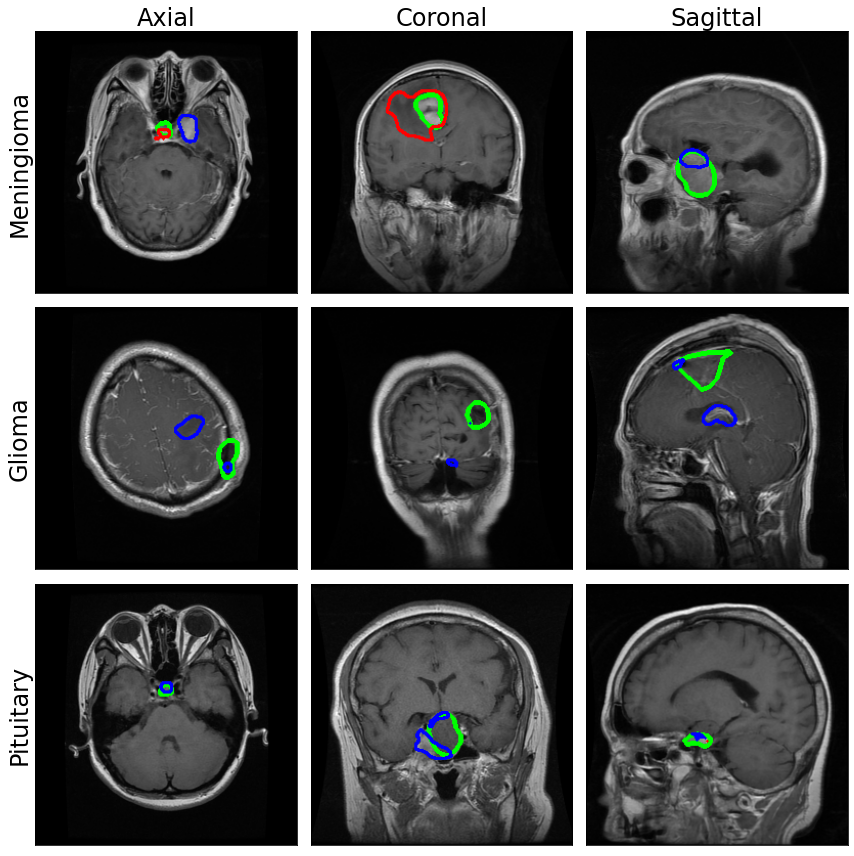

In [288]:
choosed_samples = list([893, 271, 61, 619, 211, 125, 755, 121, 6])

y_labels = list(['Meningioma', 'Glioma', 'Pituitary'])
x_labels = list(['Axial', 'Coronal', 'Sagittal'])

plt.figure(figsize=(12,12))

for i in range(9):
    sample = choosed_samples[i]
    plt.subplot(3,3,i+1)
    if i < 3:
        plt.title(x_labels[i], fontsize=24)
    if i % 3 == 0:
        plt.ylabel(y_labels[i//3], fontsize=24)
    img = np.zeros((256,256,3))
    o_img = (test_x[sample,:,:,0].T - test_x[sample,:,:,0].T.min())/(test_x[sample,:,:,0].T.max() - test_x[sample,:,:,0].T.min())
    mask = y[sample,:,:].T
    mask_prd = y_hat[sample,:,:].T
    
    lbl = mask.max()

    img[:,:,0] = o_img
    img[:,:,1] = o_img
    img[:,:,2] = o_img
    
    img = (255*img).astype(np.uint8)
    
    count_mask = (mask > 0).astype(np.uint8)
    counts,hire = cv2.findContours(count_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    img = cv2.drawContours(img, counts, -1, (0,255,0), 3)
    
    count_mask = (mask_prd == lbl).astype(np.uint8)
    counts,hire = cv2.findContours(count_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    img = cv2.drawContours(img, counts, -1, (0,0,255), 2)
    
    count_mask = (np.logical_and(mask_prd != lbl, mask_prd > 0)).astype(np.uint8)
    counts,hire = cv2.findContours(count_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    img = cv2.drawContours(img, counts, -1, (255,0,0), 2)
    

#     img[mask>0,1] = 0.8
#     img[mask_prd==lbl,2] = 0.7
#     img[np.logical_and(mask_prd!=lbl, mask_prd>0),0] = 0.7

    plt.imshow(img.astype(np.uint8), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig('PredSample_Bad.png')
plt.show()

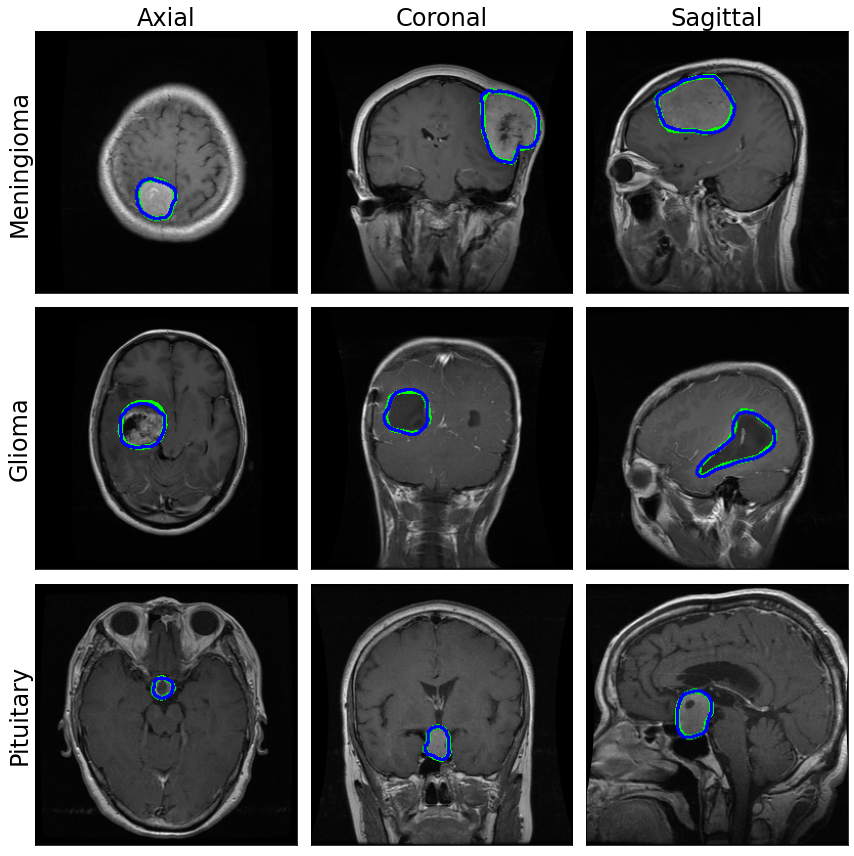

In [289]:
choosed_samples = list([18, 659, 886, 525, 697, 606, 244, 638, 334])

y_labels = list(['Meningioma', 'Glioma', 'Pituitary'])
x_labels = list(['Axial', 'Coronal', 'Sagittal'])

plt.figure(figsize=(12,12))

for i in range(9):
    sample = choosed_samples[i]
    plt.subplot(3,3,i+1)
    if i < 3:
        plt.title(x_labels[i], fontsize=24)
    if i % 3 == 0:
        plt.ylabel(y_labels[i//3], fontsize=24)
    img = np.zeros((256,256,3))
    o_img = (test_x[sample,:,:,0].T - test_x[sample,:,:,0].T.min())/(test_x[sample,:,:,0].T.max() - test_x[sample,:,:,0].T.min())
    mask = y[sample,:,:].T
    mask_prd = y_hat[sample,:,:].T
    
    lbl = mask.max()

    img[:,:,0] = o_img
    img[:,:,1] = o_img
    img[:,:,2] = o_img
    
    img = (255*img).astype(np.uint8)
    
    count_mask = (mask > 0).astype(np.uint8)
    counts,hire = cv2.findContours(count_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    img = cv2.drawContours(img, counts, -1, (0,255,0), 3)
    
    count_mask = (mask_prd == lbl).astype(np.uint8)
    counts,hire = cv2.findContours(count_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    img = cv2.drawContours(img, counts, -1, (0,0,255), 2)
    
    count_mask = (np.logical_and(mask_prd != lbl, mask_prd > 0)).astype(np.uint8)
    counts,hire = cv2.findContours(count_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    img = cv2.drawContours(img, counts, -1, (255,0,0), 2)
    

#     img[mask>0,1] = 0.8
#     img[mask_prd==lbl,2] = 0.7
#     img[np.logical_and(mask_prd!=lbl, mask_prd>0),0] = 0.7

    plt.imshow(img.astype(np.uint8), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig('PredSample.png')
plt.show()

In [213]:
nCM = confusion_matrix(y.flatten(), y_hat.flatten(), normalize='true')

In [214]:
nCM.shape

(4, 4)

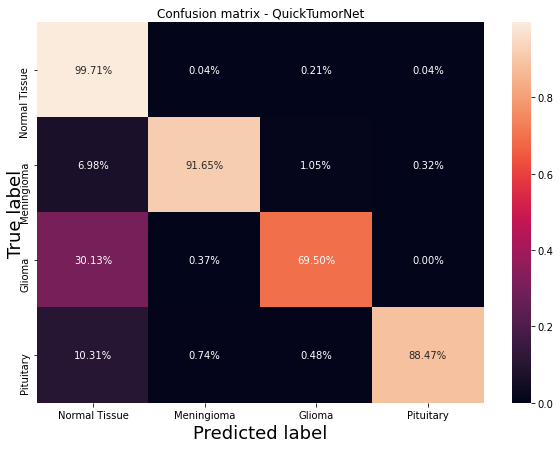

In [291]:
df_cm = pd.DataFrame(nCM, index = ['Normal Tissue', 'Meningioma', 'Glioma', 'Pituitary'],
                     columns = ['Normal Tissue', 'Meningioma', 'Glioma', 'Pituitary'])
plt.figure(figsize = (10,7))
plt.title('Confusion matrix - QuickTumorNet')
sn.heatmap(df_cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label',va='center', fontsize=18)
plt.savefig('ConfusionMat.png')
plt.show()

In [226]:
print(classification_report(y.flatten(), y_hat.flatten(), target_names=['Normal Tissue', 'Meningioma', 'Glioma', 'Pituitary']))
# plt.plot(range(10), range(10), labels=['Normal Tissue', 'Meningioma', 'Glioma', 'Pituitary'])

               precision    recall  f1-score   support

Normal Tissue       1.00      1.00      1.00  59280798
   Meningioma       0.90      0.92      0.91    241249
       Glioma       0.77      0.70      0.73    618174
    Pituitary       0.83      0.88      0.86    152899

     accuracy                           0.99  60293120
    macro avg       0.87      0.87      0.87  60293120
 weighted avg       0.99      0.99      0.99  60293120



In [57]:
import scikitplot as skplt

In [218]:
y_tt = keras.utils.to_categorical(y,num_classes=4)

In [219]:
pv_pred = list()
pv_true = list()


for i in range(4):
    pv_pred.append(prob[:,:,:,i].flatten())
    pv_true.append(y_tt[:,:,:,i].flatten())
pv_pred = np.array(pv_pred)
pv_true = np.array(pv_true)

pv_pred = pv_pred.swapaxes(0,1)
pv_true = pv_true.swapaxes(0,1)
pv_pred.shape, pv_true.shape

((60293120, 4), (60293120, 4))

In [220]:
y.flatten().shape

(60293120,)

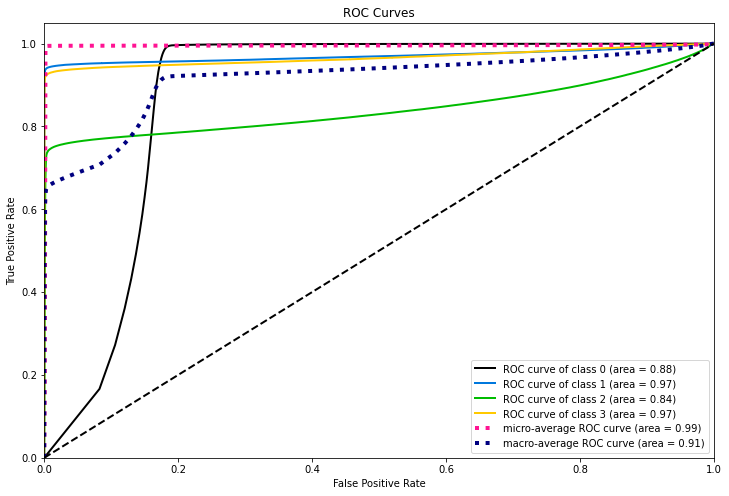

In [293]:
skplt.metrics.plot_roc(y.flatten(), pv_pred, figsize=(12,8))
plt.savefig('ROC.pdf')
plt.show()

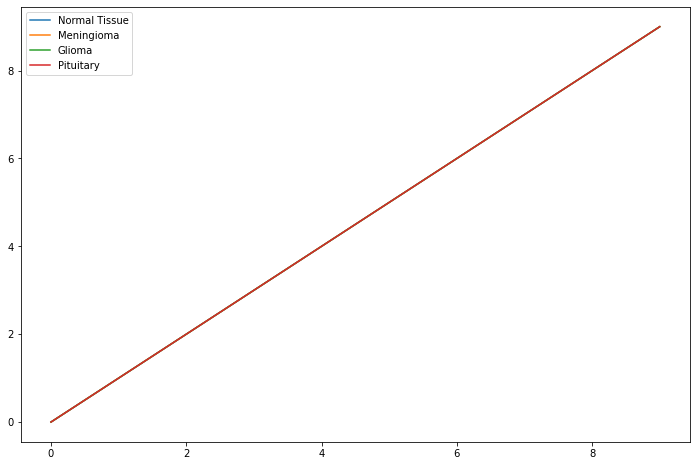

In [229]:
plt.figure(figsize=(12,8))
plt.plot(range(10), range(10), label='Normal Tissue')
plt.plot(range(10), range(10), label='Meningioma')
plt.plot(range(10), range(10), label='Glioma')
plt.plot(range(10), range(10), label='Pituitary')
plt.legend()
plt.savefig('legendsample.png')
plt.show()